# Transfer learning for Speech Emotion Recognition on Serbian acted speech

In this notebook, we evaluate a pretrained audio emotion recognition model on a newly collected
Serbian acted speech dataset. The experiments are conducted in three stages:

1. Baseline evaluation of the pretrained model on two unseen Serbian speakers.
2. Fine-tuning the model using the remaining Serbian speakers.
3. Re-evaluation on both Serbian and original English test sets.

Only the audio modality is considered.


## Setup

In [ ]:
# System setup and dependencies

!sudo apt-get update
!sudo apt-get install ffmpeg
!pip install torch==2.9.0 torchvision==0.24.0 torchaudio==2.9.0 --index-url https://download.pytorch.org/whl/cu126

In [ ]:
# Additional Python packages for AI/Audio/NLP

!pip -q install transformers datasets accelerate sentencepiece

!pip install -q librosa soundfile

!pip install torchcodec==0.8.0

In [3]:
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa

import torch
import torchaudio
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import Wav2Vec2Processor, Wav2Vec2Model

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Google Drive is used to store model checkpoints and final trained models.
from google.colab import drive
drive.mount('/content/drive')

### Config

In [ ]:
CONFIG = {
    # ========= DEVICE =========
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),

    # ========= PATHS =========
    "seac_root": Path("/content/drive/MyDrive/datasets/data_mono"),
    "meld_checkpoint": Path("/content/drive/MyDrive/models/checkpoints/audio_best.pt"),
    "model_checkpoint": Path("/content/drive/MyDrive/models/checkpoints/best_model.pt"),
    "weights_path": Path("/content/drive/MyDrive/weights/seac_audio_class_weights.pt"),

    # ========= DATA =========
    "sample_rate": 16000,
    "max_audio_length": 4.0,

    # ===== EMOTIONS (APH–SEAC) =====
    "seac_emotion_map": {
        "0": "anger",
        "1": "neutral",
        "2": "happiness",
        "3": "fear",
        "4": "sadness",
    },

   # Normalize SEAC → canonical names (MELD-style)
    "emotion_normalization": {
        "happiness": "joy",
        "neutral": "neutral",
        "anger": "anger",
        "sadness": "sadness",
        "fear": "fear",
    },

    # MELD label mapping
    "meld_label_map": {
        "neutral": 0,
        "joy": 1,
        "anger": 3,
        "sadness": 4,
        "fear": 5,
    },

    # ========= Speakers =========
    "selected_speakers": {
        "0005":"female",
        "1005":"male",
    },

    # Model
    "audio_embedding_dim": 768,
    "num_classes": 7,
    "dropout": 0.3,


    # ========= TRAINING =========
    "batch_size": 16,
    "lr_finetune": 1e-5,
    "num_epochs": 300,
    "early_stopping_patience": 5,

    # ========= REPRODUCIBILITY =========
    "seed": 42,
}


In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CONFIG["seed"])


In [7]:
label_id_to_name = {
    0: "neutral",
    1: "joy",
    2: "surprise",
    3: "anger",
    4: "sadness",
    5: "fear",
    6: "disgust"
}

## SEAC  Dataset
The SEAC dataset consists of emotionally expressive speech recordings in Serbian, organized hierarchically by speakers and emotion categories. Each speaker is represented by a separate directory containing multiple subfolders, where each subfolder corresponds to a specific emotion and includes several .wav audio files.

For the experiments in this work, a subset of the SEAC dataset is used, defined by a selected set of speakers.

Audio samples are loaded by iterating over the selected speakers and their emotion-specific subfolders. Emotion labels are first normalized and then mapped to the MELD emotion label space in order to ensure label consistency across datasets. Each sample is stored together with its audio path, normalized emotion, numerical class label, and speaker identifier.

To enable model evaluation, a custom PyTorch dataset is defined for audio processing. All audio signals are converted to mono, resampled to 16 kHz, and truncated to a fixed maximum duration. The test set consists of all loaded SEAC samples and is evaluated using a DataLoader with a batch size of one, allowing sample-level analysis.

In [8]:
def load_seac_samples(config, speakers):
    samples = []

    for speaker_id in speakers:
        speaker_path = config["seac_root"] / speaker_id

        for folder_id, emotion in config["seac_emotion_map"].items():
            emotion_path = speaker_path / folder_id
            if not emotion_path.exists():
                continue

            for wav in emotion_path.glob("*.wav"):

                # 1. normalize emotion name
                norm_emotion = config["emotion_normalization"][emotion]

                # 2. map to MELD label
                meld_label = config["meld_label_map"][norm_emotion]

                samples.append({
                    "audio_path": wav,
                    "emotion": norm_emotion,
                    "label": meld_label,
                    "speaker": speaker_id
                })

    return samples


In [9]:
class SEACAudioDataset(Dataset):
    def __init__(self, samples, sample_rate=16000, max_len=4.0):
        self.samples = samples
        self.sample_rate = sample_rate
        self.max_len = int(sample_rate * max_len)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        path = sample["audio_path"]
        label = sample["label"]

        try:
            waveform, sr = torchaudio.load(path)

            if sr != self.sample_rate:
                waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

            waveform = waveform.squeeze(0)

            if waveform.shape[0] > self.max_len:
                waveform = waveform[:self.max_len]
            else:
                pad = self.max_len - waveform.shape[0]
                waveform = torch.nn.functional.pad(waveform, (0, pad))

        except Exception:
            waveform = torch.zeros(self.max_len, dtype=torch.float32)

        return waveform, label

In [10]:
def get_all_seac_speakers(seac_root):
    return sorted([
        p.name for p in seac_root.iterdir()
        if p.is_dir()
    ])

In [ ]:
def build_audio_loader(
    samples,
    config,
    batch_size,
    shuffle,
    collate_fn=None
):
    dataset = SEACAudioDataset(
        samples,
        sample_rate=config["sample_rate"],
        max_len=config["max_audio_length"]
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )

In [12]:
def audio_collate_fn(batch):
    waveforms, labels = zip(*batch)

    waveforms = [
        torch.tensor(w, dtype=torch.float32)
        if not torch.is_tensor(w) else w
        for w in waveforms
    ]

    waveforms = torch.nn.utils.rnn.pad_sequence(
        waveforms,
        batch_first=True
    )

    labels = torch.tensor(labels, dtype=torch.long)

    return waveforms, labels

In [ ]:
samples_step1 = load_seac_samples(CONFIG,CONFIG["selected_speakers"])
print(f"Loaded {len(samples_step1)} SEAC test samples")

from collections import Counter
print(Counter([s["label"] for s in samples_step1]))
print(Counter([s["emotion"] for s in samples_step1]))

Step 1: Loaded 598 SEAC samples
Counter({0: 122, 5: 122, 4: 122, 3: 116, 1: 116})
Counter({'neutral': 122, 'fear': 122, 'sadness': 122, 'anger': 116, 'joy': 116})


In [14]:
test_loader = build_audio_loader(
    samples=samples_step1,
    config=CONFIG,
    batch_size=1,
    shuffle=False
)

## STEP 2: Speaker selection
 All remaining speakers are used for fine-tuning.

In [15]:
all_speakers = get_all_seac_speakers(CONFIG["seac_root"])
print("All speakers:", all_speakers)

selected_speakers = set(CONFIG["selected_speakers"].keys())
print("Selected (Step 1) speakers:", selected_speakers)

remaining_speakers = [
    s for s in all_speakers if s not in selected_speakers
]

print(f"Remaining speakers for fine-tuning: {len(remaining_speakers)}")
print(remaining_speakers)

All speakers: ['0001', '0002', '0003', '0005', '0006', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1019', '1020', '1021', '1023', '1024', '1025', '1026', '1027', '1028', '1030', '1031', '1032', '1033', '1034', '1036', '1037', '1038', '1039', '1040', '1043', '1044', '1045', '1046', '1047', '1049', '1050', '1051', '1052', '1053', '1054', '1057', '1058', '1060', '1061', '1062']
Selected (Step 1) speakers: {'1005', '0005'}
Remaining speakers for fine-tuning: 53
['0001', '0002', '0003', '0006', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1019', '1020', '1021', '1023', '1024', '1025', '1026', '1027', '1028', '1030', '1031', '1032', '1033', '1034', '1036', '1037', '1038', '1039', '1040', '1043', '1044', '1045', '1046', '1047', '1049', '1050', '1051', '1052', '1053', '1054', '1057', '1058', '1060', '1061', '1062']


In [16]:
samples_finetune = load_seac_samples(CONFIG, remaining_speakers)

In [17]:
train_samples, val_samples = train_test_split(
    samples_finetune,
    test_size=0.2,
    random_state=42,
    stratify=[s["label"] for s in samples_finetune]
)

In [18]:
print(f"Step 2: Loaded {len(train_samples )} SEAC train samples")

from collections import Counter
print(Counter([s["label"] for s in train_samples ]))
print(Counter([s["emotion"] for s in train_samples ]))

Step 2: Loaded 8617 SEAC train samples
Counter({0: 2601, 1: 1871, 4: 1436, 3: 1375, 5: 1334})
Counter({'neutral': 2601, 'joy': 1871, 'sadness': 1436, 'anger': 1375, 'fear': 1334})


In [19]:
print(f"Step 2: Loaded {len(val_samples )} SEAC val samples")

from collections import Counter
print(Counter([s["label"] for s in val_samples ]))
print(Counter([s["emotion"] for s in val_samples ]))

Step 2: Loaded 2155 SEAC val samples
Counter({0: 650, 1: 468, 4: 359, 3: 344, 5: 334})
Counter({'neutral': 650, 'joy': 468, 'sadness': 359, 'anger': 344, 'fear': 334})


In [20]:
train_loader = build_audio_loader(
    samples=train_samples,
    config=CONFIG,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    collate_fn=audio_collate_fn
)

In [21]:
val_loader = build_audio_loader(
    samples=val_samples,
    config=CONFIG,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    collate_fn=audio_collate_fn
)

## Audio Feature Extraction

A pre-trained Wav2Vec 2.0 base model is used to extract audio embeddings from raw waveforms.
The model is initialized with pre-trained weights and used in evaluation mode.


In [22]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec = Wav2Vec2Model.from_pretrained(
    "facebook/wav2vec2-base"
).to(CONFIG["device"])
wav2vec.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/211 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Wav2Vec2Model LOAD REPORT from: facebook/wav2vec2-base
Key                          | Status     |  | 
-----------------------------+------------+--+-
quantizer.weight_proj.weight | UNEXPECTED |  | 
project_hid.bias             | UNEXPECTED |  | 
project_hid.weight           | UNEXPECTED |  | 
project_q.bias               | UNEXPECTED |  | 
quantizer.weight_proj.bias   | UNEXPECTED |  | 
project_q.weight             | UNEXPECTED |  | 
quantizer.codevectors        | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

## Audio Classifier
A feed-forward neural network is used to classify audio embeddings extracted by Wav2Vec 2.0.
The network consists of two linear layers with a 256-dimensional hidden layer, ReLU activation, and dropout regularization.

In [23]:
class AudioClassifier(nn.Module):
    def __init__(self, config):
        super(AudioClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(config["audio_embedding_dim"], 256),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(256, config["num_classes"])
        )

    def forward(self, audio_emb):
        return self.classifier(audio_emb)

## STEP 2: Computation of Class Weights

Class weights are computed from the training labels to address class imbalance in the dataset. The labels are first converted to a NumPy array and reshaped into a one-dimensional format to ensure compatibility with the weighting procedure.

The balanced weighting scheme is then applied using the inverse class frequency, assigning higher weights to underrepresented emotion classes and lower weights to more frequent ones. These weights are finally converted to a PyTorch tensor and transferred to the appropriate device for efficient use during training.

This approach ensures that the loss function reflects the true distribution of the training data and supports more balanced model optimization.

In [ ]:
num_classes = 7
train_labels = np.array([sample["label"] for sample in train_samples])

class_counts = np.bincount(train_labels, minlength=num_classes)

class_weights = np.zeros(num_classes, dtype=np.float32)

for i in range(num_classes):
    if class_counts[i] > 0:
        class_weights[i] = len(train_labels) / (num_classes * class_counts[i])
    else:
        class_weights[i] = 0.0  # class does not exist in training set

class_weights = torch.tensor(class_weights, dtype=torch.float)
torch.save(class_weights.cpu(), CONFIG["weights_path"])

In [24]:
class_weights = torch.load(
      CONFIG["weights_path"],
      map_location=CONFIG["device"]
)

criterion = nn.CrossEntropyLoss(weight=class_weights)

## Loading model

In [ ]:
checkpoint = torch.load(
    CONFIG["meld_checkpoint"],
    map_location=CONFIG["device"]
)

audio_model = AudioClassifier(CONFIG).to(CONFIG["device"])
audio_model.load_state_dict(checkpoint["model_state"], strict=True)

<All keys matched successfully>

In [25]:
checkpoint = torch.load(
    CONFIG["model_checkpoint"],
    map_location=CONFIG["device"]
)

audio_model = AudioClassifier(CONFIG).to(CONFIG["device"])
audio_model.load_state_dict(checkpoint, strict=True)

<All keys matched successfully>

## STEP 2: Fine-tuning audio model on remaining speakers

In this step, the audio emotion recognition model is fine-tuned on the new training speakers.

The Wav2Vec encoder is used in frozen mode, and temporal pooling (mean + standard deviation) is applied over hidden states to obtain a more stable utterance-level representation. Class-weighted cross-entropy loss is used to handle class imbalance.

During training, the model is optimized using AdamW, while validation loss is monitored to guide learning rate scheduling and early stopping. The learning rate is reduced when validation loss stops improving, and training stops early if no meaningful improvement is observed for several epochs.

The best-performing model (based on validation loss) is saved and reloaded after training.

In [26]:
audio_model.train()

AudioClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

In [27]:
optimizer = torch.optim.AdamW(
    audio_model.parameters(),
    lr=CONFIG["lr_finetune"]
)

In [28]:
def temporal_pooling(hidden_states):
    mean_pool = hidden_states.mean(dim=1)
    std_pool  = hidden_states.std(dim=1)
    return mean_pool + std_pool

In [29]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

best_val_loss = float("inf")
patience = CONFIG["early_stopping_patience"]
patience_counter = 0
min_delta = 1e-3  # minimal improvement to be considered real

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-6)

In [30]:
for epoch in range(CONFIG["num_epochs"]):

    # Train
    audio_model.train()
    total_train_loss = 0.0

    for waveforms, meld_labels in train_loader:

        waveforms = waveforms.to(CONFIG["device"])
        meld_labels = meld_labels.to(CONFIG["device"])

        optimizer.zero_grad()

        with torch.no_grad():
            encoder_outputs = wav2vec(waveforms)
            hidden_states = encoder_outputs.last_hidden_state
            audio_emb = temporal_pooling(hidden_states)

        logits = audio_model(audio_emb)
        loss = criterion(logits, meld_labels)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation
    audio_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for waveforms, meld_labels in val_loader:

            waveforms = waveforms.to(CONFIG["device"])
            meld_labels = meld_labels.to(CONFIG["device"])

            encoder_outputs = wav2vec(waveforms)
            hidden_states = encoder_outputs.last_hidden_state
            audio_emb = temporal_pooling(hidden_states)

            logits = audio_model(audio_emb)
            loss = criterion(logits, meld_labels)

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(
        f"Epoch {epoch+1}: "
        f"train loss = {avg_train_loss:.4f}, "
        f"val loss = {avg_val_loss:.4f}"
    )

    # LR scheduler
    scheduler.step(avg_val_loss)

    # Early stopping
    if best_val_loss - avg_val_loss > min_delta:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(audio_model.state_dict(), CONFIG["model_checkpoint"])
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1: train loss = 0.5802, val loss = 0.5876
Epoch 2: train loss = 0.5786, val loss = 0.5872
Epoch 3: train loss = 0.5772, val loss = 0.5849
Epoch 4: train loss = 0.5783, val loss = 0.5833
Epoch 5: train loss = 0.5732, val loss = 0.5849
Epoch 6: train loss = 0.5746, val loss = 0.5829
Epoch 7: train loss = 0.5731, val loss = 0.5829
Epoch 8: train loss = 0.5742, val loss = 0.5855
Epoch 9: train loss = 0.5737, val loss = 0.5811
Epoch 10: train loss = 0.5690, val loss = 0.5826
Epoch 11: train loss = 0.5658, val loss = 0.5839
Epoch 12: train loss = 0.5660, val loss = 0.5805
Epoch 13: train loss = 0.5661, val loss = 0.5795
Epoch 14: train loss = 0.5667, val loss = 0.5794
Epoch 15: train loss = 0.5663, val loss = 0.5801
Epoch 16: train loss = 0.5636, val loss = 0.5800
Epoch 17: train loss = 0.5608, val loss = 0.5776
Epoch 18: train loss = 0.5619, val loss = 0.5786
Epoch 19: train loss = 0.5590, val loss = 0.5766
Epoch 20: train loss = 0.5568, val loss = 0.5784
Epoch 21: train loss = 0.5598

In [31]:
audio_model.load_state_dict(torch.load( CONFIG["model_checkpoint"],
    map_location=CONFIG["device"]))

<All keys matched successfully>

## Prediction Distribution Analysis

The trained audio model is evaluated on the SEAC test set using the MELD emotion label space.
For each test sample, audio embeddings are extracted with the pre-trained Wav2Vec 2.0 encoder and classified using the audio classification head.

To analyze model behavior beyond standard performance metrics, the distributions of true and predicted labels are computed.
This analysis provides insight into potential class imbalance effects and model bias by comparing the ground-truth label distribution with the distribution of model predictions.

In [32]:
from collections import Counter

audio_model.eval()

pred_counter = Counter()
target_counter = Counter()

all_preds = []
all_targets = []

with torch.no_grad():
    for waveforms, meld_labels in test_loader:

        waveforms = waveforms.to(CONFIG["device"])
        meld_labels = meld_labels.to(CONFIG["device"])

        encoder_outputs = wav2vec(waveforms)
        hidden_states = encoder_outputs.last_hidden_state
        audio_emb = temporal_pooling(hidden_states)

        logits = audio_model(audio_emb)
        preds = torch.argmax(logits, dim=1)

        for t, p in zip(meld_labels, preds):
            all_targets.append(int(t))
            all_preds.append(int(p))

            target_counter[int(t)] += 1
            pred_counter[int(p)] += 1

In [33]:
inv_meld = {v: k for k, v in CONFIG["meld_label_map"].items()}

print("Distribution of TRUE labels (MELD):")
for k, v in sorted(target_counter.items()):
    print(f"  {inv_meld.get(k, 'UNK')} ({k}): {v}")

print("\nDistribution of PREDICTED labels:")
for k, v in sorted(pred_counter.items()):
    print(f"  {inv_meld.get(k, 'UNK')} ({k}): {v}")

Distribution of TRUE labels (MELD):
  neutral (0): 122
  joy (1): 116
  anger (3): 116
  sadness (4): 122
  fear (5): 122

Distribution of PREDICTED labels:
  neutral (0): 111
  joy (1): 94
  anger (3): 95
  sadness (4): 70
  fear (5): 228


## Quantitative Evaluation and Error Analysis

This section visualizes model performance using a confusion matrix and per-class F1-scores.

The confusion matrix shows prediction counts and row-wise percentages, helping identify correct predictions and common confusions between emotion classes. The per-class F1-score bar chart highlights how well each emotion is recognized, with scores shown as percentages.

Both plots are generated from the true and predicted labels collected during inference (all_targets, all_preds) and provide a clear overview of class-wise model performance.

In [34]:
def plot_confusion_matrix_with_percentages(
    y_true,
    y_pred,
    label_id_to_name,
    title="Confusion Matrix",
    figsize=(8, 6),
    cmap="Blues"
):
    # Determine which labels actually appear
    labels = sorted(set(y_true) | set(y_pred))

    # Build confusion matrix with explicit labels
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Row-wise normalization (recall view)
    cm_percent = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    cm_percent = np.nan_to_num(cm_percent)

    # Build class names dynamically
    class_names = [label_id_to_name[l] for l in labels]

    # Create annotations
    annotations = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annotations[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        cm,
        annot=annotations,
        fmt="",
        cmap=cmap,
        xticklabels=class_names,
        yticklabels=class_names,
        square=True
    )

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title + " (Counts + Row %)")
    plt.tight_layout()
    plt.show()

In [35]:
# Plots per-class F1-scores as a bar chart.
def plot_per_class_f1(
    y_true,
    y_pred,
    label_id_to_name,
    title="Per-class F1-score",
    figsize=(8, 5),
    ylim=(0.0, 1.0)
):

    # same labels as confusion matrix
    labels = sorted(set(y_true) | set(y_pred))

    # compute F1 in fixed label order
    f1 = f1_score(y_true, y_pred, labels=labels, average=None, zero_division=0)

    # map ids → names
    class_names = [label_id_to_name[l] for l in labels]

    # plot bars
    plt.figure(figsize=figsize)
    bars = plt.bar(class_names, f1)
    plt.ylim(0, 1.0)
    plt.ylabel("F1-score")
    plt.title(title)
    plt.grid(axis="y", alpha=0.3)

    # annotate bars with percentages
    for bar, score in zip(bars, f1):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.02,
            f"{score * 100:.1f}%",
            ha="center",
            va="bottom",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

In [36]:
y_true = np.array(all_targets)
y_pred = np.array(all_preds)

## STEP 1 - Baseline evaluation on unseen Serbian speakers

Evaluation results show low overall performance of the audio-only model, with particularly poor class-wise discrimination.
The confusion matrix and per-class F1-scores reveal a strong bias toward a single predicted class, indicating a collapse in model predictions and motivating further improvements in model design.

Beyond standard performance metrics (Accuracy = 0.2508, Weighted F1 = 0.1686), we analyze the distributions of true and predicted labels to better understand the model’s behavior under cross-lingual transfer.
In particular, comparing the ground-truth label distribution with the distribution of predicted labels reveals the impact of domain mismatch and highlights potential prediction bias.

In [ ]:
acc = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average="weighted")
cm = confusion_matrix(all_targets, all_preds)

cm_sum = np.maximum(cm.sum(axis=1, keepdims=True), 1)
cm_percent = cm.astype(float) / cm_sum * 100

print(f"MELD → SEAC Audio-only results")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1:.4f}")
print("Confusion matrix:")
print(cm)

SEAC → MELD Audio-only results
Accuracy: 0.2508
Weighted F1: 0.1686
Confusion matrix:
[[14  0 74 34  0]
 [24  0 85  7  0]
 [ 7  0 98 11  0]
 [ 7  0 77 38  0]
 [ 5  0 99 18  0]]





A strong prediction bias toward the **anger** and **sadness** classes can be observed.  
Most samples from different true emotion categories are mapped to these two labels, indicating limited discriminative ability under cross-lingual transfer.

For the **anger** class, 84.5% of the samples are correctly classified, while the remaining instances are mainly misclassified as **sadness** (9.5%).  
However, other emotions such as **neutral**, **joy**, and **fear** are predominantly misclassified as either **anger** or **sadness**, demonstrating substantial class confusion.

Notably, the model fails to predict certain classes entirely.  The **disgust** and **joy** classes are never predicted.

Overall, the confusion matrix confirms that the pretrained MELD audio model does not generalize well to unseen Serbian speakers.  
The dominance of a small subset of predicted classes and the absence of meaningful predictions for others highlight the impact of language mismatch and motivate the need for speaker- and language-specific fine-tuning.



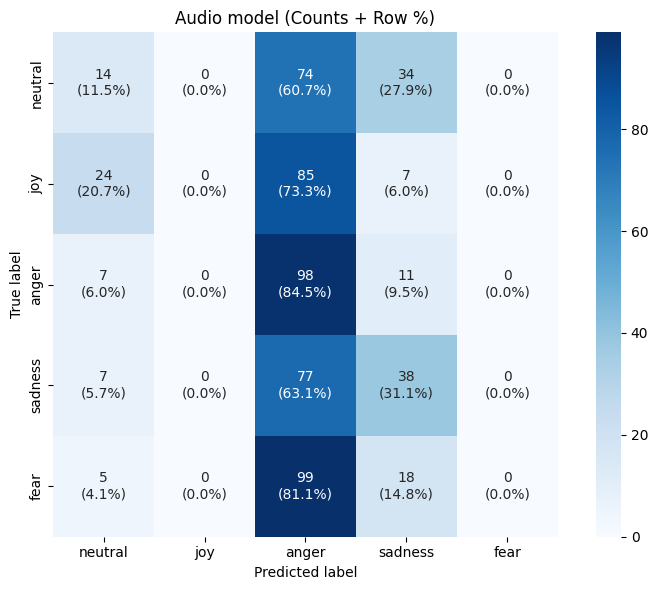

In [ ]:
plot_confusion_matrix_with_percentages(
    y_true,
    y_pred,
    label_id_to_name=label_id_to_name,
    title="Audio model"
)

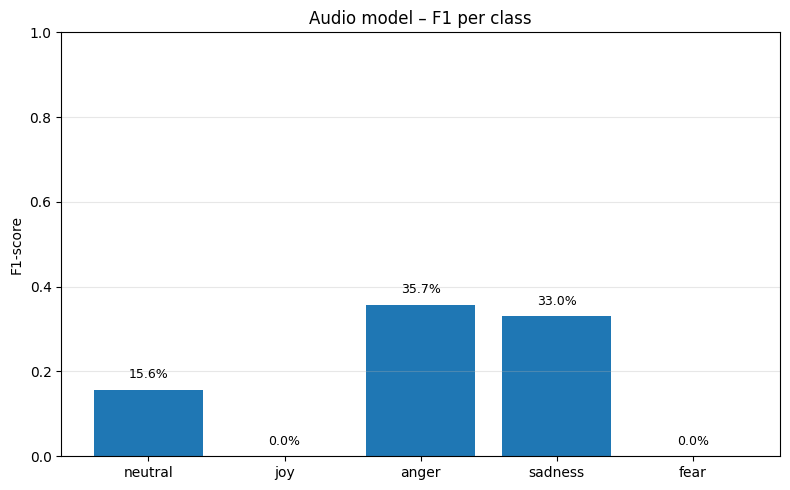

In [ ]:
plot_per_class_f1(
    y_true,
    y_pred,
    label_id_to_name=label_id_to_name,
    title="Audio model – F1 per class"
)



## STEP 2:  Speaker-specific evaluation on two SEAC speakers (fine-tuned model)

In [37]:
acc = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average="weighted")
cm = confusion_matrix(all_targets, all_preds)

cm_sum = np.maximum(cm.sum(axis=1, keepdims=True), 1)
cm_percent = cm.astype(float) / cm_sum * 100

print(f"MELD → SEAC (Fine-tuned) Audio-only results")
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1:.4f}")
print("Confusion matrix:")
print(cm)

MELD → SEAC (Fine-tuned) Audio-only results
Accuracy: 0.6672
Weighted F1: 0.6730
Confusion matrix:
[[ 88   7   0   3  24]
 [  4  67  19   0  26]
 [  2   4  69   0  41]
 [ 17   7   2  67  29]
 [  0   9   5   0 108]]


The fine-tuned model demonstrates strong improvement in emotion separability compared to the baseline model:

*  **Neutral** (72.1%) — Most samples are correctly recognized, with some confusion toward fear.
*  **Joy** (57.8%) — Moderate performance, with noticeable confusion toward fear and anger.
*  **Anger** (59.5%) — The model distinguishes anger significantly better than the baseline.
*  **Sadness** (54.9%) — Reasonable recognition, though confusion with fear remains.
*  **Fear** (88.5%) — Best recognized emotion, showing strong separability.

The fine-tuned model produces more balanced predictions across emotions, unlike the baseline model which heavily biased predictions toward anger.

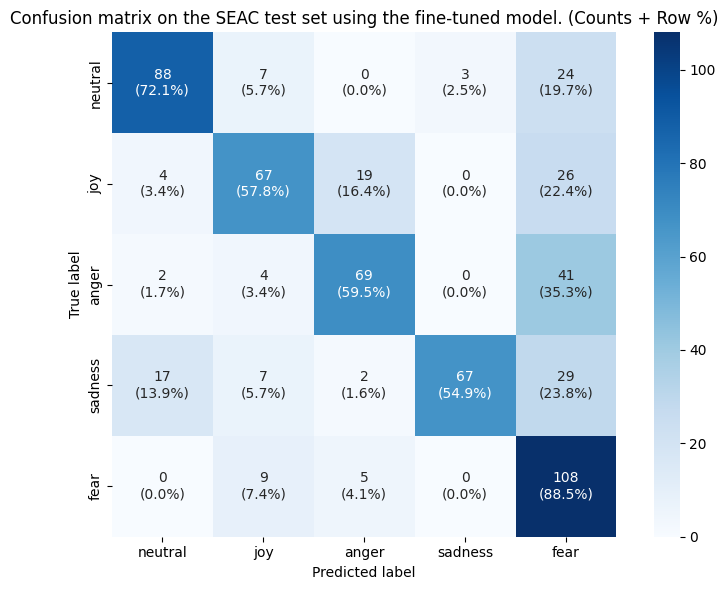

In [38]:
plot_confusion_matrix_with_percentages(
    y_true,
    y_pred,
    label_id_to_name=label_id_to_name,
    title="Confusion matrix on the SEAC test set using the fine-tuned model."
)

Fine-tuning on SEAC dramatically improves emotion recognition performance.
Unlike the baseline model, which is biased toward a few classes, the fine-tuned model achieves balanced and reliable performance across all emotions, indicating better generalization and more discriminative audio representations.

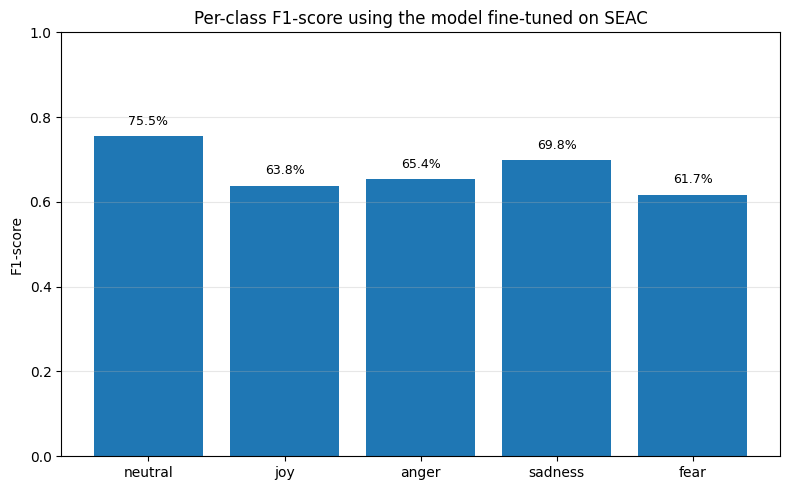

In [39]:
plot_per_class_f1(
    y_true,
    y_pred,
    label_id_to_name=label_id_to_name,
    title="Per-class F1-score using the model fine-tuned on SEAC"
)